In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hosen42","key":"2f02b851a98236ee5b3d0ff82bd16b78"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d himanshuagarwal1998/glaucomadataset

Dataset URL: https://www.kaggle.com/datasets/himanshuagarwal1998/glaucomadataset
License(s): unknown
100% 2.54G/2.54G [00:33<00:00, 90.5MB/s]
100% 2.54G/2.54G [00:33<00:00, 82.5MB/s]


In [ ]:
!unzip glaucomadataset.zip -d glaucomadataset

Archive:  glaucomadataset.zip
  inflating: glaucomadataset/Glaucoma/image100prime.tif  
  inflating: glaucomadataset/Glaucoma/image101prime.tif  
  inflating: glaucomadataset/Glaucoma/image102prime.tif  
  inflating: glaucomadataset/Glaucoma/image103prime.tif  
  inflating: glaucomadataset/Glaucoma/image104prime.tif  
  inflating: glaucomadataset/Glaucoma/image105prime.tif  
  inflating: glaucomadataset/Glaucoma/image106prime.tif  
  inflating: glaucomadataset/Glaucoma/image107prime.tif  
  inflating: glaucomadataset/Glaucoma/image108prime.tif  
  inflating: glaucomadataset/Glaucoma/image109prime.tif  
  inflating: glaucomadataset/Glaucoma/image10prime.jpg  
  inflating: glaucomadataset/Glaucoma/image10prime.tif  
  inflating: glaucomadataset/Glaucoma/image110prime.tif  
  inflating: glaucomadataset/Glaucoma/image111prime.tif  
  inflating: glaucomadataset/Glaucoma/image112prime.tif  
  inflating: glaucomadataset/Glaucoma/image113prime.tif  
  inflating: glaucomadataset/Glaucoma/image1

In [ ]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
import glob
from pandas.core.common import flatten

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Torchvision
import torchvision
from torchvision import transforms, utils

#Augmentation Library
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/splitedv2/saved_models/trial1"

# Setting the seed
# pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


import warnings
warnings.filterwarnings("ignore")

<ipython-input-6-8f5ce35f23da>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0


<Figure size 640x480 with 0 Axes>

## Spliting data

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input_folder = "/content/glaucomadataset"
output = "splitedv2"

In [ ]:
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2))

Copying files: 1022 files [00:45, 22.52 files/s]


In [ ]:
train_data_path = "/content/splitedv2/train"
test_data_path =  "/content/splitedv2/val"

## Loading and Transforming Data


This preprocessing step involves resizing the image to 32x32 pixels and randomly applying a horizontal flip. The image is first resized to the specified dimensions (32x32) which scales and adjusts the aspect ratio as necessary. Next, a random horizontal flip is applied to the image, where each pixel is flipped along the vertical axis with a probability of 50%. This step can be useful for augmenting the dataset and increasing the diversity of the training data.

In [ ]:
from torchvision import datasets,transforms
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])
train_dataset  = datasets.ImageFolder(root=train_data_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

val_dataset  = datasets.ImageFolder(root=train_data_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None)


In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
split = [train_size,val_size]

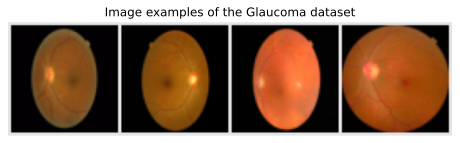

In [ ]:
train_set, _ = torch.utils.data.random_split(train_dataset, split)
# pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(train_dataset, split)

# Loading the test set
test_set = datasets.ImageFolder(root=test_data_path,
                                 transform=data_transform)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
GLA_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(GLA_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the Glaucoma dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()

## Transformers for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, we have simply added a positional encoding to the input feature vectors, and the model learned by itself what to do with it. So, why not do the same thing on images? This is exactly what Alexey Dosovitskiy et al. proposed in their paper “An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale”. Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, we split an image of, for example,
 pixels into 9
 patches. Each of those patches is considered to be a “word”/”token” and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task. A nice GIF visualization of the architecture is shown below (figure credit - Phil Wang):

 ![](https://1.bp.blogspot.com/-_mnVfmzvJWc/X8gMzhZ7SkI/AAAAAAAAG24/8gW2AHEoqUQrBwOqjhYB37A7OOjNyKuNgCLcBGAsYHQ/s16000/image1.gif)

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

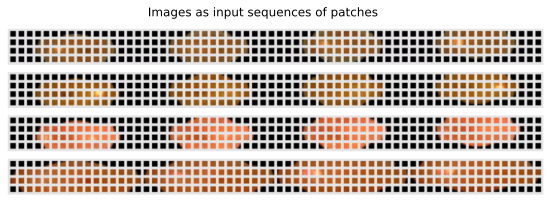

In [ ]:
img_patches = img_to_patch(GLA_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(GLA_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(GLA_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [ ]:
len(img_patches[0])

256

Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model. Since we have discussed the fundamentals of Multi-Head Attention in Tutorial 6, we will use the PyTorch module nn.MultiheadAttention (docs) here. Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by Ruibin Xiong et al. in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage. A visualization of the difference between the standard Post-LN and the Pre-LN version is shown below.

![](https://gcdnb.pbrd.co/images/X1aivEZprUUu.png?o=1)

In [ ]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

A linear projection layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each
 patch independently as input.

A classification token that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.

Learnable positional encodings that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.

An MLP head that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.

With those components in mind, let’s implement the full Vision Transformer below:

In [ ]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input
        x = x.to("cuda")
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

Finally, we can put everything into a PyTorch Lightning Module as usual. We use torch.optim.AdamW as the optimizer, which is Adam with a corrected weight decay implementation. Since we use the Pre-LN Transformer version, we do not need to use a learning rate warmup stage anymore. Instead, we use the same learning rate scheduler as the CNNs in our previous tutorial on image classification.


In [ ]:
class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        x = x.to("cuda")
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [ ]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
                         accelerator="gpu" ,
                         devices=1,
                         precision=16, #mixed precision
                         max_epochs=50,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch"),EarlyStopping(monitor="val_loss", mode="min"),TQDMProgressBar(refresh_rate=20)])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
#         pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=True)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [ ]:
model, results = train_model(model_kwargs={
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 256,
                                'num_classes': 2,
                                'dropout': 0.2
                            },
                            lr=3e-4)
print("ViT results", results)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | train | [128, 3, 64, 64] | [128, 2] 
-----------------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.969    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9329268336296082     │
│         test_loss         │    0.12730126082897186    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.946601927280426, 'val': 0.9329268336296082}


In [ ]:
%tensorboard --logdir /content/splitedv2/saved_models/trial1/ViT/lightning_logs

In [ ]:
!ls /content/splitedv2/saved_models/trial1/ViT

lightning_logs
